## 1. Datenimport und Initialisierung

In diesem Abschnitt werden die OpenJur-Urteilstexte aus dem Datenverzeichnis eingelesen und die technische Datenbasis für die nachfolgenden Verarbeitungsschritte geschaffen. Dazu werden die benötigten Bibliotheken importiert und die verfügbaren Textdateien identifiziert.


### 1.1 Import der benötigten Bibliotheken

Zu Beginn werden die für die weitere Verarbeitung erforderlichen Python-Bibliotheken importiert. Diese umfassen Funktionen für Dateizugriffe, reguläre Ausdrücke, Datenverarbeitung mit Pandas sowie den Export der Ergebnisse im JSON-Format.

In [2]:
#Import
import os
import re
import json
import pandas as pd

### 1.2 Einlesen der OpenJur-Urteilstexte 

In diesem Schritt werden alle identifizierten Urteilstexte aus dem Datenverzeichnis eingelesen. Jede Datei wird über den Dateinamen einer eindeutigen Fallkennung (`case_id`) zugeordnet. Die Texte bilden die Rohdatenbasis für die nachfolgenden Extraktions- und Filterprozesse. Der Datenpfad wird im Code parametriert (`DATA_DIR`), um eine reproduzierbare Ausführung zu gewährleisten.

In [3]:
# (.txt) Dateien einlesen
DATA_DIR = "../data/Gerichtsurteile_Openjur" 
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".txt")]

print("Pfad:", os.path.abspath(DATA_DIR))
print("Anzahl .txt:", len(files))
print("Erste 10 Dateien:", files[:10])


Pfad: c:\Users\humme\OneDrive\Dokumente\Uni Ulm\ds_law\backend\data\Gerichtsurteile_Openjur
Anzahl .txt: 2375
Erste 10 Dateien: ['2090187.txt', '2112111.txt', '2112115.txt', '2112117.txt', '2112118.txt', '2112119.txt', '2112121.txt', '2112123.txt', '2124977.txt', '2126821.txt']


---

## 2. Extraktion relevanter Urteilsbestandteile und Selektion der Landgerichtsurteile

In diesem Abschnitt werden die eingelesenen Urteilstexte weiterverarbeitet, um für die nachfolgende Analyse relevante Textbestandteile gezielt zu extrahieren. Hierzu zählen insbesondere ein begrenzter Kopfbereich zur Voranalyse sowie der Tenor als Kern der gerichtlichen Entscheidung. Die strukturierte Aufbereitung dieser Textsegmente bildet die Grundlage für Filter-, Klassifikations- und Extraktionsschritte in den folgenden Abschnitten.

### 2.1 Aufbau des DataFrames und Extraktion eines Kopfbereichs

Die eingelesenen Texte werden in einem DataFrame (`df`) gespeichert. Zusätzlich wird ein begrenzter Kopfbereich (`head`) aus den ersten Zeichen extrahiert, da strukturelle Metadaten wie Gerichtstyp, Entscheidungsart und Zitierzeilen typischerweise am Anfang des Dokuments auftreten. Dieser Kopfbereich dient als effizienter Suchraum für die spätere Identifikation von Landgerichtsurteilen.


In [4]:
rows = []
for fn in files:
    case_id = fn.replace(".txt", "")
    path = os.path.join(DATA_DIR, fn)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    rows.append({"case_id": case_id, "text": text})

df = pd.DataFrame(rows)
print("Gesamt eingelesen:", len(df))


Gesamt eingelesen: 2375


In [5]:
HEAD_CHARS = 8000
df["head"] = df["text"].astype(str).str.slice(0, HEAD_CHARS)

print("Head-Länge (Beispiel):", len(df.loc[0, "head"]))


Head-Länge (Beispiel): 8000


### 2.2 Extraktion des Tenors

Der Tenor enthält die eigentliche gerichtliche Entscheidung und ist daher für die inhaltliche Bewertung besonders relevant. Mithilfe regulärer Ausdrücke wird der Textabschnitt zwischen der Überschrift „Tenor“ und den nachfolgenden Abschnitten (z. B. „Tatbestand“ oder „Gründe“) extrahiert und in einer separaten Spalte gespeichert.

In [6]:
def extract_tenor(text: str) -> str:
    if not isinstance(text, str):
        return ""

    m_start = re.search(r"\bTenor\b", text, flags=re.IGNORECASE)
    if not m_start:
        return ""

    start = m_start.end()

    # Begrenztes Suchfenster nach dem Tenor (robuster gegen Navigation)
    window = text[start:start + 20000]

    m_end = re.search(
        r"\b(Tatbestand|Gründe|Gruende|Entscheidungsgründe|Entscheidungsgruende)\b",
        window,
        flags=re.IGNORECASE
    )

    end = start + m_end.start() if m_end else min(len(text), start + 8000)
    return text[start:end].strip()
df["tenor"] = df["text"].apply(extract_tenor)
print("Tenor vorhanden:", (df["tenor"].str.len() > 0).sum(), "von", len(df))


Tenor vorhanden: 2362 von 2375


### 2.3 Identifikation von Landgerichtsurteilen (LG)

Die Selektion der Landgerichtsurteile erfolgt anhand einer OpenJur-spezifischen Zitierzeile im Kopfbereich (Regex: „Einfach“ gefolgt von „LG“). Auf dieser Grundlage wird eine boolesche Variable erzeugt und der Teilkorpus df_lg gebildet.

In [7]:
# Wir suchen nach der Zeile, die mit "Einfach" beginnt, gefolgt von "LG"
# Der Regex r"Einfach\s*\n\s*LG" stellt sicher, dass LG direkt darunter steht
pattern_zitierung_lg = r"Einfach\s*\n\s*LG"

# Wir wenden das auf die Spalte an, die den Kopftext enthält
df["is_landgericht"] = df["head"].str.contains(pattern_zitierung_lg, regex=True, na=False)

# Jetzt erstellen wir den sauberen Dataframe
df_lg = df[df["is_landgericht"] == True].copy()

print("-" * 40)
print(f"✅ Echte LG-Urteile (über Zitierzeile): {len(df_lg)}")
print("-" * 40)

----------------------------------------
✅ Echte LG-Urteile (über Zitierzeile): 1189
----------------------------------------


### 2.4 Segmentierung der Urteile in juristische Abschnitte
Für die spätere Extraktion werden die Urteile in juristisch sinnvolle Teile zerlegt: Rubrum, Tenor, Tatbestand und Entscheidungsgründe. Dadurch kann das Modell gezielt relevante Passagen verarbeiten.
Die Segmentierung dient dazu, spätere Analysen gezielt auf entscheidungsrelevante Abschnitte (insb. Tenor und Entscheidungsgründe) zu fokussieren.


In [8]:
def split_judgment(text):
    """
    Teilt ein Urteil in Rubrum, Tenor, Tatbestand und Entscheidungsgründe auf.
    """
    segments = {
        "rubrum": "",
        "tenor": "",
        "tatbestand": "",
        "entscheidungsgruende": ""
    }
    
    # Muster für die Abschnittsüberschriften
    # Das Rubrum ist alles vor dem Tenor
    m_tenor = re.search(r"\bTenor\b", text, re.IGNORECASE)
    m_tatbestand = re.search(r"\bTatbestand\b", text, re.IGNORECASE)
    m_gruende = re.search(r"\b(Entscheidungsgründe|Entscheidungsgruende|Gründe|Gruende)\b", text, re.IGNORECASE)
    
    if m_tenor:
        segments["rubrum"] = text[:m_tenor.start()].strip()
        
        # Tenor bis Tatbestand
        if m_tatbestand:
            segments["tenor"] = text[m_tenor.end():m_tatbestand.start()].strip()
            
            # Tatbestand bis Gründe
            if m_gruende:
                segments["tatbestand"] = text[m_tatbestand.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tatbestand"] = text[m_tatbestand.end():].strip()
        else:
            # Falls kein Tatbestand gefunden wird, Tenor bis zum Ende oder Gründen
            if m_gruende:
                segments["tenor"] = text[m_tenor.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tenor"] = text[m_tenor.end():].strip()
                
    return segments

# Beispielanwendung auf den Dataframe
df_lg['segments'] = df_lg['text'].apply(split_judgment)

## 3 Prompt-Generierung und Pilotierung der LLM-Extraktion (Gemini Batch)
Um API- und Token-Limits zu berücksichtigen, werden OpenJur-spezifische Navigationselemente aus dem Rubrum entfernt und alle Abschnitte in ihrer Länge begrenzt. Auf Basis dieser vorverarbeiteten Textsegmente wird ein standardisierter Prompt generiert, der die Extraktion der abgestimmten Variablen im JSON-Format steuert.
Die segmentweise Längenbegrenzung dient der Einhaltung von Token-Limits sowie der Reduktion von Kosten und Laufzeit, ohne entscheidungsrelevante Passagen (insb. Tenor und Entscheidungsgründe) zu verlieren.


### 3.1 Aufbereitung der Segmente und Definition des Extraktions-Prompts

Der Prompt wurde so konzipiert, dass er neben technischen Features (Motor, Kilometer) gezielt die Anforderungen der Aufgabenstellung erfüllt. Kernaspekte sind die Identifikation des Gerichtstyps sowie die Differenzierung der Zielvariable in Schadensersatz, Klageabweisung und prozessuale Sonderfälle („Sonstige“). Durch explizite Anweisungen zum Ausschluss von Zinsen und zur Erkennung von Streitwertbeschlüssen wird eine hohe Datenqualität für das anschließende Machine Learning sichergestellt.

In [47]:
def clean_rubrum(rubrum: str) -> str:
    if not isinstance(rubrum, str):
        return ""

    blacklist = [
        "rechtsprechung", "aktuell", "trending", "filter",
        "über openjur", "spenden", "api", "hilfe",
        "startseite", "bundesland", "gerichtsbarkeit",
        "impressum", "datenschutz", "nutzungsbedingungen",
        "fachzeitschriften", "suchen", "changelog", "einfach",
        "json", "bibtex", "ris"
    ]

    lines = []
    for line in rubrum.splitlines():
        l = line.strip().lower()
        if not l:
            continue
        if any(b in l for b in blacklist):
            continue
        lines.append(line.strip())

    return "\n".join(lines[:5])   

def slim_segments(segments):
    return {
        "rubrum": clean_rubrum(segments.get("rubrum") or "")[:2500],
        "tenor": (segments.get("tenor") or "")[:4000],
        "tatbestand": (segments.get("tatbestand") or "")[:3500],
        "entscheidungsgruende": (segments.get("entscheidungsgruende") or "")[:7000],
    }
def get_gemini_prompt(segments):
    """
    Erstellt den finalen Prompt basierend auf den Urteilssegmenten.
    """
    s = slim_segments(segments)

    prompt = f"""
Analysiere die folgenden Abschnitte eines Gerichtsurteils zum Dieselskandal und extrahiere die Variablen präzise als JSON-Liste. 

### URTEILS-BESTANDTEILE:
RUBRUM (Kopfbereich mit Gericht & Datum): 
{s['rubrum']}

TENOR (Ergebnis): 
{s['tenor']}

TATBESTAND (Sachverhalt): 
{s['tatbestand']}

ENTSCHEIDUNGSGRÜNDE (Rechtliche Würdigung): 
{s['entscheidungsgruende']}

### EXTRAKTIONS-AUFGABE:
Extrahiere folgende Variablen (bei Nichtfinden 'null' angeben):

WICHTIG (Validierung & Datenqualität):
1) **Gerichtstyp** muss explizit angegeben werden (z.B. "Landgericht", "Oberlandesgericht", "Amtsgericht").  
2) **Sonstige-Kategorie (prozessuale Dokumente):** Falls das Dokument **keine materielle Entscheidung über einen Schadensersatzanspruch** enthält (z.B. nur Streitwertfestsetzung/-beschluss, Prozesskostenhilfe/PKH, Kostenentscheidung ohne Sachentscheidung, Ablehnungsgesuch/Befangenheit, rein prozessualer Beschluss), dann setze zwingend:
   - LABEL_Anspruch_Schadensersatz = false
   - LABEL_Schadensersatzhoehe_Betrag = null
   - LABEL_Schadensersatzhoehe_Range = "Sonstige"
3) **Betrag ohne Zinsen:** LABEL_Schadensersatzhoehe_Betrag ist **ohne Zinsen/Verzugszinsen/Nebenforderungen** anzugeben.

1. **Input-Variablen (Features):**
   - Dieselmotor_Typ: (Beispiel: "EA 189", "EA 288")
   - Art_Abschalteinrichtung: (Beispiel: "Umschaltlogik", "Thermofenster")
   - KBA_Rueckruf: (Boolean: true/false - Beispiel: true)
   - Fahrzeugstatus: ("Neuwagen" oder "Gebrauchtwagen")
   - Fahrzeugmodell_Baureihe: (Beispiel: "VW Golf 2.0 TDI")
   - Update_Status: (Boolean: true/false/null - Beispiel: false)
   - Kilometerstand_Kauf: (Integer - Beispiel: 15200)
   - Kilometerstand_Klageerhebung: (Integer - Beispiel: 45000)
   - Erwartete_Gesamtlaufleistung: (Integer - Beispiel: 250000)
   - Kaufdatum: (Date YYYY-MM-DD - Beispiel: 2014-05-12)
   - Uebergabedatum: (Date YYYY-MM-DD - Beispiel: 2014-05-20)
   - Datum_Klageerhebung: (Date YYYY-MM-DD - Beispiel: 2018-11-03)
   - Beklagten_Typ: ("Händler" oder "Hersteller")
   - Datum_Urteil: (Date YYYY-MM-DD - Beispiel: 2019-12-17)
   - Kaufpreis: (Float in EUR - Beispiel: 25900.00)
   - Nacherfuellungsverlangen_Fristsetzung: ("Ja", "Nein", "Entbehrlich")
   - Klageziel: ("Rückabwicklung", "Minderung", "Schadensersatz")
   - Rechtsgrundlage: (Beispiel: "§ 826 BGB", "§ 437 BGB")

2. **Zielvariablen (Labels):**
   - LABEL_Anspruch_Schadensersatz (Boolean: true/false - Beispiel: true)
   - LABEL_Schadensersatzhoehe_Betrag (Float in EUR - Beispiel: 18450.50)
   - LABEL_Schadensersatzhoehe_Range (Beispiel: "< 5000", "5000-10000", "10000-15000", "15000-20000", "20000-25000", "> 25000", "Abgewiesen")

### AUSGABEFORMAT:
Antworte NUR mit einem validen JSON-Objekt in einer Liste:
[{{
  "case_id": null,
  "Gerichtstyp": null,
  "Dieselmotor_Typ": null,
  "Art_Abschalteinrichtung": null,
  "KBA_Rueckruf": null,
  "Fahrzeugstatus": null,
  "Fahrzeugmodell_Baureihe": null,
  "Update_Status": null,
  "Kilometerstand_Kauf": null,
  "Kilometerstand_Klageerhebung": null,
  "Erwartete_Gesamtlaufleistung": null,
  "Kaufdatum": null,
  "Uebergabedatum": null,
  "Datum_Klageerhebung": null,
  "Nachweis_Aufklaerung": null,
  "Beklagten_Typ": null,
  "Datum_Urteil": null,
  "Kaufpreis": null,
  "Nacherfuellungsverlangen_Fristsetzung": null,
  "Klageziel": null,
  "Rechtsgrundlage": null,
  "LABEL_Anspruch_Schadensersatz": null,
  "LABEL_Schadensersatzhoehe_Betrag": null,
  "LABEL_Schadensersatzhoehe_Range": null
}}]
""".strip()

    return prompt


In [ ]:
'''import time
import pandas as pd
import json
import re
import os
from google import genai

# --- 1. EINSTELLUNGEN ---
MODEL_NAME = "models/gemini-2.5-flash"
CHECKPOINT_FILE = "gemini_results_checkpoint.csv" # Sicherungsdatei

# API Key Client starten
api_key = os.getenv("GEMINI_API_KEY") 
client = genai.Client(api_key=api_key)

# --- 2. HILFSFUNKTIONEN ---
def extract_json_from_llm(text: str):
    text = re.sub(r"^```json\s*|\s*```$", "", text.strip(), flags=re.MULTILINE)
    m = re.search(r"(\[\s*\{.*?\}\s*\]|\{.*?\})", text, flags=re.DOTALL)
    if not m: raise ValueError("Kein JSON gefunden")
    return json.loads(m.group(1))

# --- 3. DER HAUPT-LAUF (ROBUST & KORREKTER ZÄHLER) ---
working_df = df_lg.copy() 
results = []
errors = []

print(f"🚀 Starte 'Pay-as-you-go' Lauf für {len(working_df)} Fälle mit {MODEL_NAME}...")
print(f"💾 Zwischenergebnisse werden alle 50 Fälle in '{CHECKPOINT_FILE}' gespeichert.")

start_time = time.time()

# KORREKTUR: Wir nutzen enumerate(), um einen echten Zähler (i) zu haben
for i, (index, row) in enumerate(working_df.iterrows()):
    case_id = row['case_id']
    
    # Retry-Logik
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # 1. Prompt holen (MIT Sicherheits-Check für Strings)
            segs = row["segments"]
            if isinstance(segs, str):
                import ast
                segs = ast.literal_eval(segs)
            
            # (Hier war dein Einrückungsfehler)
            prompt = get_gemini_prompt(segs)
            
            # 2. Anfrage senden (Das fehlte in deinem Code!)
            response = client.models.generate_content(
                model=MODEL_NAME,
                contents=prompt
            )
            
            # 3. Ergebnis verarbeiten
            data = extract_json_from_llm(response.text)
            if isinstance(data, list): data = data[0]
            
            data["case_id"] = case_id
            results.append(data)
            
            # Fortschrittsanzeige & Checkpoint (nutzt jetzt 'i' statt 'index')
            if (i + 1) % 50 == 0:
                elapsed = time.time() - start_time
                
                # Checkpoint speichern
                pd.DataFrame(results).to_csv(CHECKPOINT_FILE, index=False)
                
                print(f"✅ {i + 1}/{len(working_df)} geschafft ({elapsed:.1f}s) -> 💾 Checkpoint gesichert.")
            
            break # Erfolg -> Raus aus Retry

        except Exception as e:
            error_msg = str(e)
            # Exponentielles Warten: 5s, 10s, 15s
            wait_time = 5 * (attempt + 1)
            
            if "429" in error_msg or "RESOURCE_EXHAUSTED" in error_msg:
                if attempt < max_retries - 1:
                    print(f"⏳ Limit bei {case_id}. Warte {wait_time}s (Versuch {attempt+1}/{max_retries})...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"❌ Limit-Fehler bei {case_id} endgültig.")
                    errors.append({"case_id": case_id, "error": "429 Limit"})
            else:
                print(f"⚠️ Fehler bei {case_id}: {error_msg}")
                errors.append({"case_id": case_id, "error": error_msg})
                break

print("\n🎉 FERTIG!")
print(f"Erfolgreich extrahiert: {len(results)}")

# --- 4. FINALES SPEICHERN ---
df_final = pd.DataFrame(results)
filename = "gemini_results_paid_complete.csv"
df_final.to_csv(filename, index=False)
print(f"✅ Finale Daten gespeichert als: {filename}")

# Aufräumen: Wenn alles geklappt hat, löschen wir den Checkpoint
if os.path.exists(CHECKPOINT_FILE):
    os.remove(CHECKPOINT_FILE)
    print("🧹 Checkpoint-Datei entfernt (Job erledigt).")'''

🚀 Starte 'Pay-as-you-go' Lauf für 1189 Fälle mit models/gemini-2.5-flash...
💾 Zwischenergebnisse werden alle 50 Fälle in 'gemini_results_checkpoint.csv' gespeichert.
✅ 50/1189 geschafft (976.1s) -> 💾 Checkpoint gesichert.
✅ 100/1189 geschafft (1830.6s) -> 💾 Checkpoint gesichert.
✅ 150/1189 geschafft (2801.6s) -> 💾 Checkpoint gesichert.
✅ 200/1189 geschafft (3741.5s) -> 💾 Checkpoint gesichert.
✅ 250/1189 geschafft (4609.3s) -> 💾 Checkpoint gesichert.
✅ 300/1189 geschafft (5551.5s) -> 💾 Checkpoint gesichert.
✅ 350/1189 geschafft (6510.9s) -> 💾 Checkpoint gesichert.
✅ 400/1189 geschafft (7372.8s) -> 💾 Checkpoint gesichert.
✅ 450/1189 geschafft (8183.8s) -> 💾 Checkpoint gesichert.
✅ 500/1189 geschafft (8984.6s) -> 💾 Checkpoint gesichert.
✅ 550/1189 geschafft (9833.6s) -> 💾 Checkpoint gesichert.
✅ 600/1189 geschafft (10653.7s) -> 💾 Checkpoint gesichert.
✅ 650/1189 geschafft (11524.9s) -> 💾 Checkpoint gesichert.
✅ 700/1189 geschafft (12349.7s) -> 💾 Checkpoint gesichert.
✅ 750/1189 geschafft 

## 4 Verarbeitung der Modellantworten und Erstellung des Extraktions-Datensatzes

In diesem Abschnitt werden die Ergebnisse des direkten API-Durchlaufs (`gemini_results_paid_complete.csv`) eingelesen und mit den ursprünglichen Urteilstexten verknüpft. Um eine hohe Datenqualität für das anschließende Machine Learning zu gewährleisten, erfolgen hier zudem wichtige Bereinigungsschritte:

1.  **Daten-Merge:** Die KI-Extraktionen werden über die eindeutige `case_id` mit den Originaltexten (`df_lg`) zusammengeführt. Dabei wird sichergestellt, dass die ID in beiden Datensätzen als String behandelt wird, um Datenverlust zu vermeiden.
2.  **Bereinigung von Geldbeträgen:** Die Funktion `clean_money_robust` konvertiert diverse deutsche Währungsformate (z. B. "25.000,00 €", "1.000 Euro" oder "25.000") zuverlässig in numerische Gleitkommazahlen (`float`), indem sie Tausenderpunkte und Währungssymbole korrekt interpretiert und entfernt.
3.  **Standardisierung der Zielvariable:** Die Funktion `determine_target_label` vereinheitlicht die unterschiedlichen Rückgabeformate des Modells (z. B. "True", "yes", "1") in saubere Kategorien ("Schadensersatz", "Abgewiesen", "Sonstige").

Abschließend wird der bereinigte Gesamtdatensatz sowohl im CSV-Format (für manuelle Prüfung) als auch im Parquet-Format (für performante Weiterverarbeitung) gespeichert.

In [10]:
# Wir laden die Ergebnisse, bereinigen Datentypen und führen sie mit den Originaltexten zusammen.
%pip install pyarrow 
import pandas as pd
import numpy as np
import os
import re

# 1. Konfiguration & Laden
RESULTS_FILENAME = "gemini_results_paid_complete.csv"

if not os.path.exists(RESULTS_FILENAME):
    raise FileNotFoundError(f"Datei {RESULTS_FILENAME} fehlt! Bitte Kapitel 3 ausführen.")

print(f"📥 Lade Ergebnisse aus: {RESULTS_FILENAME}")
df_extracted = pd.read_csv(RESULTS_FILENAME)

# IDs für Merge sicherstellen (String)
df_lg["case_id"] = df_lg["case_id"].astype(str)
df_extracted["case_id"] = df_extracted["case_id"].astype(str)

# 2. Merge: Originaltexte (df_lg) + KI-Daten (df_extracted)
df_dataset = pd.merge(df_lg, df_extracted, on="case_id", how="inner")

print(f"✅ Merge erfolgreich: {len(df_dataset)} Datensätze.")

# --- BEREINIGUNGS-FUNKTIONEN ---

def clean_money_robust(val):
    """ Wandelt Strings wie '25.000,00' oder '1000 €' sicher in Floats um. """
    if pd.isna(val) or str(val).strip().lower() in ["null", "none", "nan", ""]:
        return 0.0
    
    if isinstance(val, (int, float)):
        return float(val)

    s = str(val).strip()
    # Entferne alles außer Ziffern, Punkt, Komma, Minus
    s = re.sub(r'[^\d.,-]', '', s)
    
    # Logik für deutsche Tausenderpunkte (z.B. 25.000 -> 25000)
    if "," in s:
        s = s.replace(".", "")  # Tausender weg
        s = s.replace(",", ".") # Dezimal-Komma zu Punkt
    else:
        # Fall "25.000" (ohne Komma) -> Punkt ist Tausender
        if "." in s:
            parts = s.split(".")
            # Wenn nach dem letzten Punkt genau 3 Ziffern kommen und davor auch was steht
            if len(parts) > 1 and len(parts[-1]) == 3:
                s = s.replace(".", "")
    
    try:
        return float(s)
    except ValueError:
        return 0.0

def determine_target_label(row):
    """ Bestimmt die Zielklasse: Schadensersatz, Abgewiesen oder Sonstige. """
    # 1. Sonstige (Prozessual)
    if str(row.get("LABEL_Schadensersatzhoehe_Range")).lower() == "sonstige":
        return "Sonstige"
    
    # 2. Anspruch (True/False prüfen)
    val = str(row.get("LABEL_Anspruch_Schadensersatz")).strip().lower()
    if val in ["true", "1", "1.0", "ja", "yes"]:
        return "Schadensersatz"
    
    return "Abgewiesen"

# --- ANWENDUNG ---

# Geld bereinigen
if "Kaufpreis" in df_dataset.columns:
    df_dataset["Kaufpreis_num"] = df_dataset["Kaufpreis"].apply(clean_money_robust)

if "LABEL_Schadensersatzhoehe_Betrag" in df_dataset.columns:
    df_dataset["Schadensersatz_Betrag_num"] = df_dataset["LABEL_Schadensersatzhoehe_Betrag"].apply(clean_money_robust)

# Label erstellen
df_dataset["target_label"] = df_dataset.apply(determine_target_label, axis=1)

# Speichern
df_dataset.to_parquet("lg_diesel_urteile_final.parquet", index=False)
df_dataset.to_csv("lg_diesel_urteile_final.csv", index=False)

print("-" * 30)
print("📊 Verteilung Target-Label:")
print(df_dataset["target_label"].value_counts(dropna=False))
print(f"\n💾 Datensatz gespeichert (Parquet & CSV).")

Note: you may need to restart the kernel to use updated packages.
📥 Lade Ergebnisse aus: gemini_results_paid_complete.csv
✅ Merge erfolgreich: 1189 Datensätze.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


------------------------------
📊 Verteilung Target-Label:
target_label
Abgewiesen        572
Schadensersatz    531
Sonstige           86
Name: count, dtype: int64

💾 Datensatz gespeichert (Parquet & CSV).


### 4.3 Zusammenführung mit Metadaten und Speicherung (CSV/Parquet) (Platzhalter)

In diesem finalen Schritt der Datenextraktion werden die extrahierten Modellantworten (`df_extracted`) mit den ursprünglichen Metadaten und Urteilstexten der Landgerichte (`df_lg`) zusammengeführt. Die Verknüpfung erfolgt über die eindeutige `case_id`, um eine konsistente Zuordnung zwischen den technischen Features (z. B. Motortyp, Kilometerstand) und den Zielvariablen (Schadensersatzhöhe, Anspruchsstatus) zu gewährleisten.

Der resultierende Gesamtdatensatz wird in zwei Formaten exportiert:
* **CSV-Format:** Zur einfachen manuellen Überprüfung der Extraktionsergebnisse in Excel/Tabellenkalkulationen.
* **Parquet-Format:** Zur effizienten Weiterverarbeitung in der Machine-Learning-Phase (Kapitel 5), da dieses Format Datentypen (z. B. numerische Beträge ohne Zinsen) verlustfrei speichert.

Damit ist die Datenbasis für die nachfolgende semantische Analyse und Modellierung vollständig vorbereitet.

In [11]:
import pandas as pd
import numpy as np
import re

# 1. Datentypen angleichen
df_lg["case_id"] = df_lg["case_id"].astype(str)
df_extracted["case_id"] = df_extracted["case_id"].astype(str)

# 2. Merge durchführen
df_dataset = pd.merge(
    df_lg,
    df_extracted,
    on="case_id",
    how="inner"
)

print(f"✅ Merge abgeschlossen: {df_dataset.shape[0]} Urteile")

# 3. Target Label erstellen
def determine_label(row):
    if str(row.get("LABEL_Schadensersatzhoehe_Range")).lower() == "sonstige":
        return "Sonstige"
    val = row.get("LABEL_Anspruch_Schadensersatz")
    if str(val).lower() == "true":
        return "Schadensersatz"
    return "Abgewiesen"

df_dataset["target_label"] = df_dataset.apply(determine_label, axis=1)

# 4. KORRIGIERTE Geld-Funktion (Wichtig!)
def clean_money(val):
    if pd.isna(val) or str(val).strip().lower() in ["null", "none", "nan", ""]:
        return 0.0
    
    s = str(val).strip()
    s = re.sub(r'[^\d.,-]', '', s) # Nur Zahlen, Punkt, Komma
    
    # Deutsche Logik: Wenn Komma da ist, muss Punkt weg (Tausender)
    if "," in s:
        s = s.replace(".", "")      # 25.000,00 -> 25000,00
        s = s.replace(",", ".")     # 25000,00 -> 25000.00
    else:
        # Fall: "25.000" (ohne Komma)
        if "." in s and len(s.split(".")[-1]) == 3:
             s = s.replace(".", "")
             
    try:
        return float(s)
    except:
        return 0.0

if "Kaufpreis" in df_dataset.columns:
    df_dataset["Kaufpreis_num"] = df_dataset["Kaufpreis"].apply(clean_money)

# 5. Speichern
OUTPUT_BASENAME = "lg_diesel_urteile_final"
df_dataset.to_csv(f"{OUTPUT_BASENAME}.csv", index=False, encoding="utf-8")
df_dataset.to_parquet(f"{OUTPUT_BASENAME}.parquet", index=False)

print(f"✅ Fertig. Datei gespeichert. Kaufpreise sind jetzt korrekt.")

✅ Merge abgeschlossen: 1189 Urteile
✅ Fertig. Datei gespeichert. Kaufpreise sind jetzt korrekt.


### 4.4 Datenaufteilung und Validierungskonzept

Der Datensatz wird auf Fall-Ebene (`case_id`) in einen Trainings- (80 %) und einen Testdatensatz (20 %) aufgeteilt.  
Der Trainingsdatensatz wird anschließend mittels **5-facher stratified Cross-Validation** für die Modellselektion und Hyperparameter-Optimierung genutzt.

Dieses Vorgehen erlaubt eine effiziente Nutzung der verfügbaren, kostenintensiv extrahierten Labels, während der Testdatensatz vollständig unberührt bleibt und ausschließlich zur finalen Evaluation der Modellleistung dient.

In [12]:
# %% [markdown]
# ### 4.4 Datenaufteilung und Validierungskonzept (Final & Repariert)
# Wir teilen den GESAMTEN Datensatz in Train/Test.

# %%
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import numpy as np

# 1. Split auf dem gesamten DataFrame durchführen
# WICHTIG: Das .fillna("false") verhindert den "Input contains NaN" Fehler!
df_lg_train, df_lg_test = train_test_split(
    df_dataset,
    test_size=0.20,
    random_state=42,
    stratify=df_dataset["LABEL_Anspruch_Schadensersatz"].fillna("false").astype(str).str.lower()
)

# 2. Robuste Reinigungs-Funktion für die Labels
def to_int_label(s):
    return (
        s.astype(str).str.lower()
         .map({"true": 1, "false": 0, "1": 1, "0": 0, "ja": 1, "nein": 0})
         .astype(float)   # erlaubt NaN als Zwischenschritt
         .fillna(0)       # NaN/Fehler werden zu 0 (Abgewiesen)
         .astype(int)
    )

# 3. Anwendung: Wir bereinigen die Spalte direkt im DataFrame!
# Damit sind die DataFrames für die Zukunft sauber.
df_lg_train["LABEL_Anspruch_Schadensersatz"] = to_int_label(df_lg_train["LABEL_Anspruch_Schadensersatz"])
df_lg_test["LABEL_Anspruch_Schadensersatz"]  = to_int_label(df_lg_test["LABEL_Anspruch_Schadensersatz"])

# 4. y-Vektoren für Scikit-Learn ziehen
y_train = df_lg_train["LABEL_Anspruch_Schadensersatz"].values
y_test  = df_lg_test["LABEL_Anspruch_Schadensersatz"].values

# 5. CV-Objekt erstellen
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("✅ Split erfolgreich und Labels bereinigt!")
print(f"📊 Training: {len(df_lg_train)} Fälle (davon {sum(y_train)}x Schadensersatz)")
print(f"📊 Test:     {len(df_lg_test)} Fälle (davon {sum(y_test)}x Schadensersatz)")
print(f"Probe-ID im Training: {df_lg_train.iloc[0]['case_id']}")

✅ Split erfolgreich und Labels bereinigt!
📊 Training: 951 Fälle (davon 430x Schadensersatz)
📊 Test:     238 Fälle (davon 107x Schadensersatz)
Probe-ID im Training: 2304966


## 5. Datenaufbereitung für maschinelles Lernen

In diesem Abschnitt werden die Urteilstexte für die nachgelagerte prädiktive Modellierung aufbereitet. Hierzu erfolgt zunächst eine juristisch angepasste Textvorverarbeitung und die Ableitung numerischer Textrepräsentationen. Die für die supervised Lernphase erforderlichen Zielvariablen werden im Rahmen der LLM-basierten Extraktion (Abschnitt 4) erzeugt und anschließend mit den Textmerkmalen zusammengeführt (Abschnitt 5.4).
Ziel der Datenaufbereitung ist es, die extrahierten Merkmale in eine konsistente, auswertbare Form zu überführen, fehlende oder uneinheitliche Angaben zu behandeln und die Zielvariablen für die spätere Analyse eindeutig zu definieren.

### 5.1 Juristische Textvorverarbeitung

In [14]:
# %%
import pandas as pd
import re
import spacy

# 1. Setup: Spacy laden
try:
    nlp = spacy.load("de_core_news_lg", disable=["ner", "parser"])
except Exception:
    print("⚠️ Modell nicht gefunden. Lade Fallback...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "de_core_news_lg"])
    nlp = spacy.load("de_core_news_lg", disable=["ner", "parser"])

# --- HILFSFUNKTIONEN ---

def legal_preprocess(text):
    """ Reinigt den Text (Lemmatisierung, Stoppwörter, Platzhalter). """
    if not isinstance(text, str) or not text:
        return ""
    
    # 1. Text normalisieren
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text) # HTML-Reste weg
    
    # 2. PLATZHALTER SETZEN
    money_regex = r'\d{1,3}(?:\.\d{3})*(?:,\d+)?\s*(?:eur|€|euro)'
    text = re.sub(money_regex, ' PLATZHALTER_BETRAG ', text)
    
    paragraph_regex = r'§+\s*\d+[a-z]?'
    text = re.sub(paragraph_regex, ' PLATZHALTER_PARAGRAPH ', text)
    
    text = re.sub(r'\b(19|20)\d{2}\b', ' PLATZHALTER_JAHR ', text)
    
    # 3. Spacy Pipeline
    doc = nlp(text)
    
    # 4. Filterung
    tokens = [
        t.lemma_ for t in doc 
        if not t.is_stop and not t.is_punct and not t.is_space and len(t.text) > 1
    ]
    
    return " ".join(tokens)

def build_text_for_embedding(row):
    segs = row.get("segments")
    if not isinstance(segs, dict):
        try:
            import ast
            segs = ast.literal_eval(str(segs))
        except:
            pass
            
    if not isinstance(segs, dict):
         return str(row["text"])[:10000]

    tenor = segs.get("tenor") or ""
    gruende = segs.get("entscheidungsgruende") or ""
    combined = (tenor + " " + gruende).strip()
    
    if len(combined) < 100:
        return str(row["text"])[:10000]
    
    return combined[:15000]

# --- HAUPTVERARBEITUNG (ohne Ladebalken) ---

# 1. TRAININGS-DATEN
print("⚙️ Verarbeite TRAININGS-Daten (bitte warten, dauert ca. 1-2 Minuten)...")
df_lg_train["text_for_embedding"] = df_lg_train.apply(build_text_for_embedding, axis=1)
# Hier stand vorher progress_apply -> jetzt nur apply
df_lg_train["cleaned_text"] = df_lg_train["text_for_embedding"].apply(legal_preprocess)
print("✅ Training fertig.")

# 2. TEST-DATEN
print("⚙️ Verarbeite TEST-Daten...")
df_lg_test["text_for_embedding"] = df_lg_test.apply(build_text_for_embedding, axis=1)
# Hier auch nur apply
df_lg_test["cleaned_text"] = df_lg_test["text_for_embedding"].apply(legal_preprocess)
print("✅ Test fertig.")

# 3. Ergebnis-Check
print("-" * 30)
print(f"✅ Preprocessing abgeschlossen.")
print(f"Train Samples: {len(df_lg_train)}")
try:
    sample_text = df_lg_train[df_lg_train["cleaned_text"].str.contains("betrag", na=False)]["cleaned_text"].iloc[0]
    print("Beispiel:", sample_text[:100] + "...")
except:
    pass

⚙️ Verarbeite TRAININGS-Daten (bitte warten, dauert ca. 1-2 Minuten)...
✅ Training fertig.
⚙️ Verarbeite TEST-Daten...
✅ Test fertig.
------------------------------
✅ Preprocessing abgeschlossen.
Train Samples: 951
Beispiel: i. Klage zulässig.da Landgericht Kassel örtlich zuständig gemäß PLATZHALTER_PARAGRAPH zpo Gericht ör...


### 5.2 Text-Vektorisierung mittels Word2Vec
Das Modell lernt semantische Relationen ausschließlich aus dem Trainingskorpus.

In [16]:
# %% [markdown]
# ### 5.2 Text-Vektorisierung mittels Word2Vec
# Das Modell lernt semantische Relationen ausschließlich aus dem Trainingskorpus.

# %%
from gensim.models import Word2Vec
import pandas as pd # Wichtig für die Korrektur

df_train = df_lg_train

# Tokenisierung (nur nicht-leere Texte)
train_sentences = [
    str(t).split()
    for t in df_train["cleaned_text"].fillna("")
    if str(t).strip()
]

print("Training des Word2Vec-Modells auf den Trainingsdaten...")
w2v_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    seed=42
)

print("y_train distribution (aus 4.4):")
print(pd.Series(y_train).value_counts(dropna=False))

print(f"✅ Word2Vec-Modell trainiert. Vokabulargröße: {len(w2v_model.wv)} Wörter.")
print(f"✅ Zielvariable y_train erstellt (N={len(y_train)}).")

Training des Word2Vec-Modells auf den Trainingsdaten...
y_train distribution (aus 4.4):
0    521
1    430
Name: count, dtype: int64
✅ Word2Vec-Modell trainiert. Vokabulargröße: 19518 Wörter.
✅ Zielvariable y_train erstellt (N=951).


### 5.3 Aufbau des Analyse-Datensatzes
Nach der Vektorisierung führen wir die mathematischen Ergebnisse in einer strukturierten Feature-Matrix zusammen. Wir wandeln die Sparse-Matrix in einen übersichtlichen DataFrame um und verknüpfen jedes Urteil über die eindeutige case_id mit seinen Textmerkmalen. Diese Struktur ist essentiell, um im nächsten Schritt die durch das LLM extrahierten Zielvariablen (Schadensersatz oder Abweisung) präzise jeder Beobachtung zuordnen zu können. Damit stellen wir sicher, dass der Datensatz modellunabhängig konzipiert ist und eine solide Basis für die nachgelagerte prädiktive Modellierung bietet.

In [17]:
import numpy as np

# 1. Hilfsfunktion zur Erstellung eines Dokument-Vektors
def get_doc_vector(doc, model):
    """ Erstellt einen Durchschnittsvektor aller bekannten Wörter im Urteil. """
    words = [w for w in str(doc).split() if w in model.wv]
    if not words:
        # Falls kein Wort des Urteils im Training vorkam, geben wir einen Null-Vektor zurück
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

# 2. Vektorisierung der Trainings- und Testdaten
# WICHTIG: Wir nutzen das w2v_model aus Schritt 5.2 (nur auf Train trainiert!)
print("Vektorisierung der Trainingsdaten...")
X_train_vec = np.array([get_doc_vector(text, w2v_model) for text in df_lg_train["cleaned_text"]])


print("Vektorisierung der Testdaten (mit Trainings-Modell)...")
X_test_vec = np.array([get_doc_vector(text, w2v_model) for text in df_lg_test["cleaned_text"]])

# 3. Auswahl der strukturierten Features (aus der Gemini-Extraktion in Abschnitt 4)
# Wir füllen fehlende Werte (NaN) mit 0, damit die ML-Modelle damit arbeiten können.
struct_cols = ['Kaufpreis_num']
X_train_structured = df_lg_train[struct_cols].fillna(0)
X_test_structured = df_lg_test[struct_cols].fillna(0)

# 4. Umwandlung der Word2Vec-Vektoren in DataFrames
emb_cols = [f"emb_{i}" for i in range(X_train_vec.shape[1])]
df_train_features = pd.DataFrame(X_train_vec, columns=emb_cols)
df_test_features = pd.DataFrame(X_test_vec, columns=emb_cols)

# 5. Finale Zusammenführung (Struktur + Text-Embeddings)
# WICHTIG: reset_index(drop=True) sorgt dafür, dass die Zeilen beim Zusammenfügen exakt matchen!
X_train_final = pd.concat([X_train_structured.reset_index(drop=True), df_train_features], axis=1)
X_test_final = pd.concat([X_test_structured.reset_index(drop=True), df_test_features], axis=1)

print("-" * 30)
print(f"✅ Feature-Matrizen erfolgreich erstellt.")
print(f"📊 Training: {X_train_final.shape[0]} Urteile, {X_train_final.shape[1]} Features")
print(f"📊 Test:     {X_test_final.shape[0]} Urteile, {X_test_final.shape[1]} Features")

Vektorisierung der Trainingsdaten...
Vektorisierung der Testdaten (mit Trainings-Modell)...
------------------------------
✅ Feature-Matrizen erfolgreich erstellt.
📊 Training: 951 Urteile, 101 Features
📊 Test:     238 Urteile, 101 Features


## 6. Analyse und Auswertung

Entscheidungsbaum

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, accuracy_score

# 1. Modell-Initialisierung
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")

# 2. Cross-Validation (auf Trainingsdaten)
# Wir prüfen die Stabilität über 5 Folds
cv_results_dt = cross_validate(
    dt_model, X_train_final, y_train, 
    cv=cv, # Das cv-Objekt (StratifiedKFold) aus Abschnitt 4.4
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_train_score=False
)

print(f"--- Cross-Validation (Train) ---")
print(f"Mittlere Accuracy: {cv_results_dt['test_accuracy'].mean():.4f} (+/- {cv_results_dt['test_accuracy'].std():.4f})")
print(f"Mittlerer Recall:   {cv_results_dt['test_recall'].mean():.4f}")

# 3. Finales Training & Test-Evaluation
dt_model.fit(X_train_final, y_train)
y_pred_dt = dt_model.predict(X_test_final)

print(f"\n--- Finale Evaluation (Testset) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(classification_report(y_test, y_pred_dt))

--- Cross-Validation (Train) ---
Mittlere Accuracy: 0.8727 (+/- 0.0288)
Mittlerer Recall:   0.8651

--- Finale Evaluation (Testset) ---
Accuracy: 0.8403
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       131
           1       0.81      0.85      0.83       107

    accuracy                           0.84       238
   macro avg       0.84      0.84      0.84       238
weighted avg       0.84      0.84      0.84       238



Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

# 1. Modell-Initialisierung
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced")

# 2. Cross-Validation (auf Trainingsdaten)
cv_results_rf = cross_validate(
    rf_model, X_train_final, y_train, 
    cv=cv, 
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_train_score=False
)

print(f"--- Cross-Validation (Train) ---")
print(f"Mittlere Accuracy: {cv_results_rf['test_accuracy'].mean():.4f} (+/- {cv_results_rf['test_accuracy'].std():.4f})")

# 3. Finales Training & Test-Evaluation
rf_model.fit(X_train_final, y_train)
y_pred_rf = rf_model.predict(X_test_final)

print(f"\n--- Finale Evaluation (Testset) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

--- Cross-Validation (Train) ---
Mittlere Accuracy: 0.9264 (+/- 0.0145)

--- Finale Evaluation (Testset) ---
Accuracy: 0.9076
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       131
           1       0.91      0.88      0.90       107

    accuracy                           0.91       238
   macro avg       0.91      0.90      0.91       238
weighted avg       0.91      0.91      0.91       238



Gradient Boosting

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.5 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/8.1 MB 1.2 MB/s eta 0:00:07
   ----- ---------------------------------- 1.0/8.1 MB 1.3 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.1 MB 1.3 MB/s eta 0:00:06
   ------- -------------------------------- 1.6/8.1 MB 1.3 MB/s eta 0:00:06
   --------- ------------------------------ 1.8/8.1 MB 1.3 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/8.1 MB 1.3 MB/s eta 0:00:05
   ----------- ---------------------------- 2.4/8.1 MB 1.3 MB/s eta 0:00:05
   ------------ --------------------------- 2.6/8.1 MB 1.2 MB/s eta 0:00:05
   -------------- ------------------------- 2.9/8.1 MB 1.2 MB/s eta 0:00:05
   --------------- ------------------------ 3.1/8.1 MB 1.2 MB/s eta 0:00:05
   ---------------- ------


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


--- Cross-Validation (Train) ---
Mittlere Accuracy: 0.9232

--- Finale Evaluation (Testset) ---
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       131
           1       0.88      0.90      0.89       107

    accuracy                           0.90       238
   macro avg       0.90      0.90      0.90       238
weighted avg       0.90      0.90      0.90       238



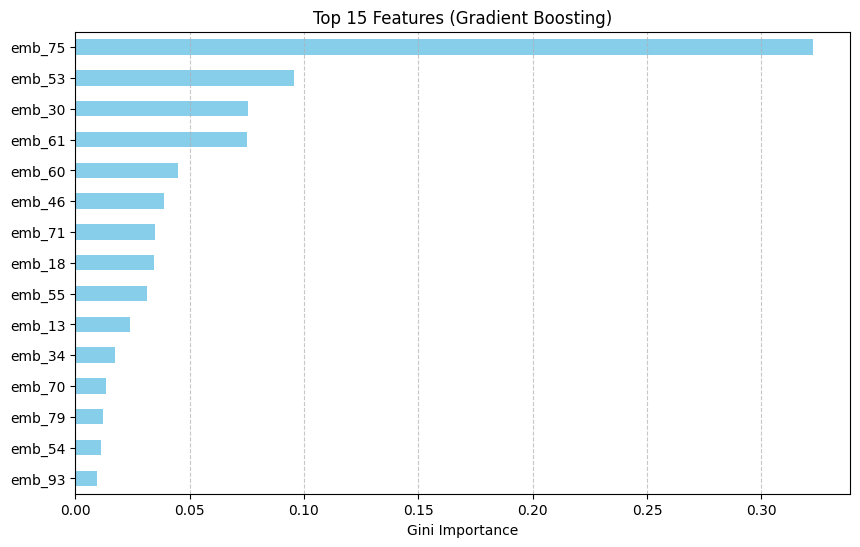

In [21]:
%pip install matplotlib
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import pandas as pd

# 1. Modell-Initialisierung
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# 2. Cross-Validation (auf Trainingsdaten)
cv_results_gb = cross_validate(
    gb_model, X_train_final, y_train, 
    cv=cv, 
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_train_score=False
)

print(f"--- Cross-Validation (Train) ---")
print(f"Mittlere Accuracy: {cv_results_gb['test_accuracy'].mean():.4f}")

# 3. Finales Training & Test-Evaluation
gb_model.fit(X_train_final, y_train)
y_pred_gb = gb_model.predict(X_test_final)

print(f"\n--- Finale Evaluation (Testset) ---")
print(classification_report(y_test, y_pred_gb))

# 4. Visualisierung der Feature Importance
# Wir zeigen die Top 15 Merkmale (Strukturvariablen + Embeddings)
importances = pd.Series(gb_model.feature_importances_, index=X_train_final.columns)
plt.figure(figsize=(10, 6))
importances.nlargest(15).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 15 Features (Gradient Boosting)")
plt.xlabel("Gini Importance")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

evtl. SHAP Werte für Erklärbarkeit